# CS 296 Mini Project

Marc Anthony Reyes

In [1]:
#force package installation 
!pip install split-folders imgaug gym pydot graphviz

In [2]:
import os

from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import (
    decode_predictions,
    preprocess_input,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import (
    categorical_crossentropy,
    MeanAbsoluteError,
    MeanSquaredError,
)
from tensorflow.keras.models import (
    Model,
)
from tensorflow.keras.utils import get_file, load_img, plot_model

import numpy as np
import glob
import cv2 as cv
import time

from matplotlib import pyplot as plt
from skimage.metrics import (
    structural_similarity,
    peak_signal_noise_ratio,
    mean_squared_error,
)
from statistics import mean
from random import (
    sample,
    randrange,
)
from splitfolders import ratio as splitfolders_ratio
from shutil import rmtree
from imgaug import augmenters as iaa
from itertools import combinations_with_replacement
from collections import defaultdict
from PIL import ImageEnhance, Image
from IPython.display import clear_output

from gym import Env
from gym.spaces import Box, Discrete

2024-05-26 09:34:37.072858: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 09:34:37.072943: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 09:34:37.074731: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-26 09:34:37.084532: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-26 09:34:38.191173: W tensorflow/compiler/tf2

In [3]:
def plot_training_rewards(rewards, moving_avg_window_size=None):
    if moving_avg_window_size is not None:
        moving_avg_total_reward = []
        for i in range(len(rewards)):
            window = rewards[max(0, i - moving_avg_window_size + 1) : i + 1]
            window_avg = mean(window)
            moving_avg_total_reward.append(window_avg)

    fig, ax = plt.subplots(figsize=(15, 5))

    ax.plot(range(len(rewards)), rewards, label="Total reward", color="orange")
    ax.set_xlabel("Episodes")
    if moving_avg_window_size is not None:
        ax.plot(
            range(len(moving_avg_total_reward)),
            moving_avg_total_reward,
            label="Total reward moving average",
        )
        ax.legend(loc="upper left")


def show_image_grid(image_path, grid_size, image_size):
    fig = plt.figure(figsize=image_size)
    rows, columns = grid_size
    for i in range(1, columns * rows + 1):
        fn = np.random.choice(image_path)
        img = Image.open(fn)
        fig.add_subplot(rows, columns, i)
        plt.axis("off")
        plt.imshow(img)
    plt.show()


def compare_images(images, titles, image_size):
    number_of_images = len(images)
    fig, axes = plt.subplots(1, number_of_images, figsize=image_size)
    for i in range(number_of_images):
        axes[i].imshow(images[i])
        axes[i].set_title(titles[i])
        axes[i].axis("off")
    plt.show()


def display_image(image) -> None:
    plt.figure()
    plt.imshow(image)

In [4]:
dataset_path = "underwater_dataset"
splitted_dataset_path = "splitted_dataset"

In [5]:
def split_dataset(training_set_size, test_set_size, validation_set_size):

    if os.path.isdir(splitted_dataset_path):
        rmtree(splitted_dataset_path)

    splitfolders_ratio(
        dataset_path,
        output=splitted_dataset_path,
        ratio=(training_set_size, test_set_size, validation_set_size),
    )

In [6]:
training_set_size = 0.6
test_set_size = 0.2
validation_set_size = 0.2

split_dataset(training_set_size, test_set_size, validation_set_size)

Copying files: 1840 files [00:02, 887.03 files/s]


In [7]:
images_raw = sorted(glob.glob(dataset_path + "/raw-890/*.png"), key=len)
images_ref = sorted(glob.glob(dataset_path + "/reference-890/*.png"), key=len)
print("Total number of raw images: ", len(images_raw))
print("Total number of reference images: ", len(images_ref))

images_raw_train = sorted(
    glob.glob(splitted_dataset_path + "/train/raw-890/*.png"), key=len
)
images_raw_test = sorted(
    glob.glob(splitted_dataset_path + "/test/raw-890/*.png"), key=len
)
images_raw_val = sorted(
    glob.glob(splitted_dataset_path + "/val/raw-890/*.png"), key=len
)
print("Total number of raw images for training: ", len(images_raw_train))
print("Total number of raw images for validation: ", len(images_raw_val))
print("Total number of raw images for testing: ", len(images_raw_test))

images_ref_train = sorted(
    glob.glob(splitted_dataset_path + "/train/reference-890/*.png"), key=len
)
images_ref_test = sorted(
    glob.glob(splitted_dataset_path + "/test/reference-890/*.png"), key=len
)
images_ref_val = sorted(
    glob.glob(splitted_dataset_path + "/val/reference-890/*.png"), key=len
)
print("Total number of reference images for training: ", len(images_ref_train))
print("Total number of reference images for validation: ", len(images_ref_val))
print("Total number of reference images for testing: ", len(images_ref_test))

Total number of raw images:  890
Total number of reference images:  890
Total number of raw images for training:  534
Total number of raw images for validation:  178
Total number of raw images for testing:  178
Total number of reference images for training:  534
Total number of reference images for validation:  178
Total number of reference images for testing:  178


In [8]:
def sample_images(source="train", target_size=None):

    if source == "test":
        random_img_path = np.random.choice(images_raw_test)
    elif source == "val":
        random_img_path = np.random.choice(images_raw_val)
    else:
        random_img_path = np.random.choice(images_raw_train)

    random_img = random_img_path.split("/").pop()

    file_raw = splitted_dataset_path + "/" + source + "/raw-890/" + random_img
    raw_img = load_img(path=file_raw, target_size=target_size)
    file_ref = splitted_dataset_path + "/" + source + "/reference-890/" + random_img
    ref_img = load_img(path=file_ref, target_size=target_size)

    return raw_img, ref_img

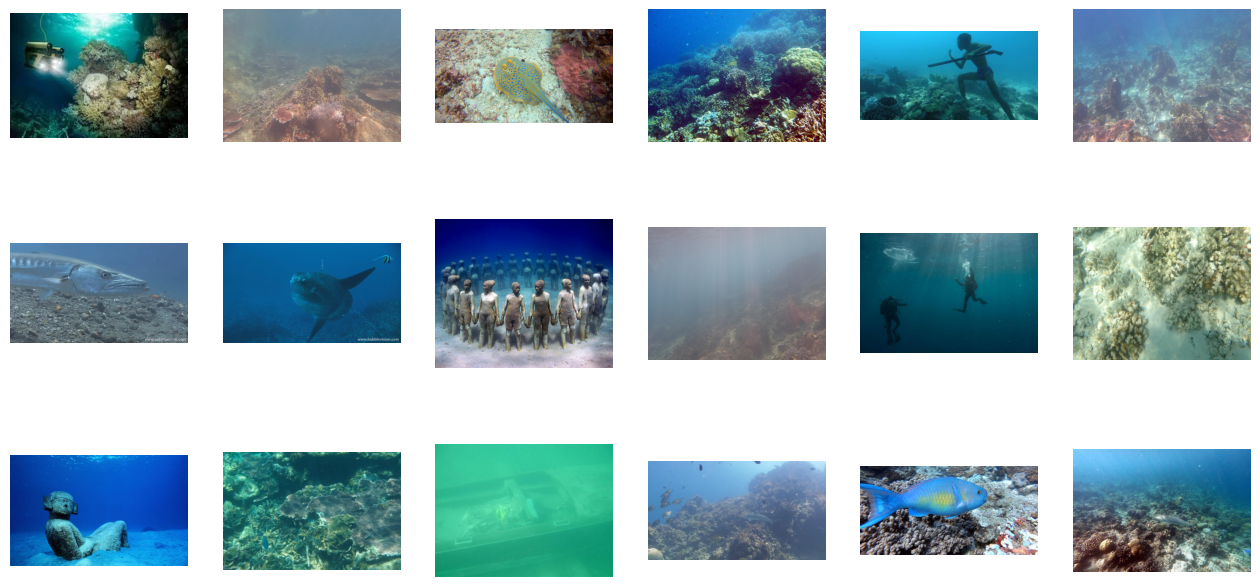

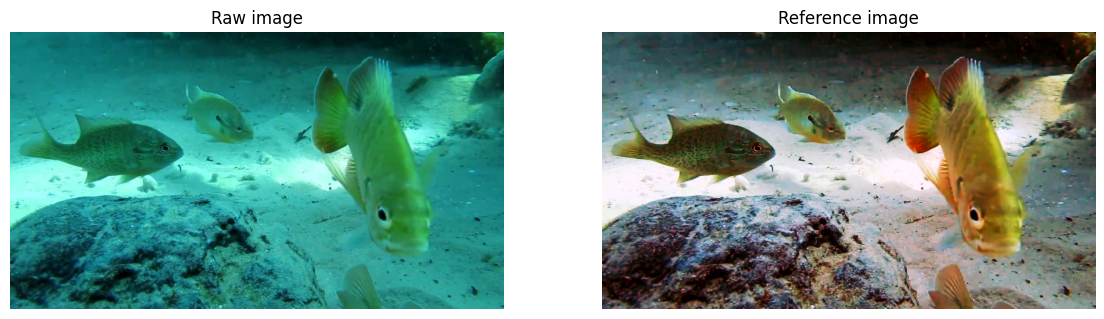

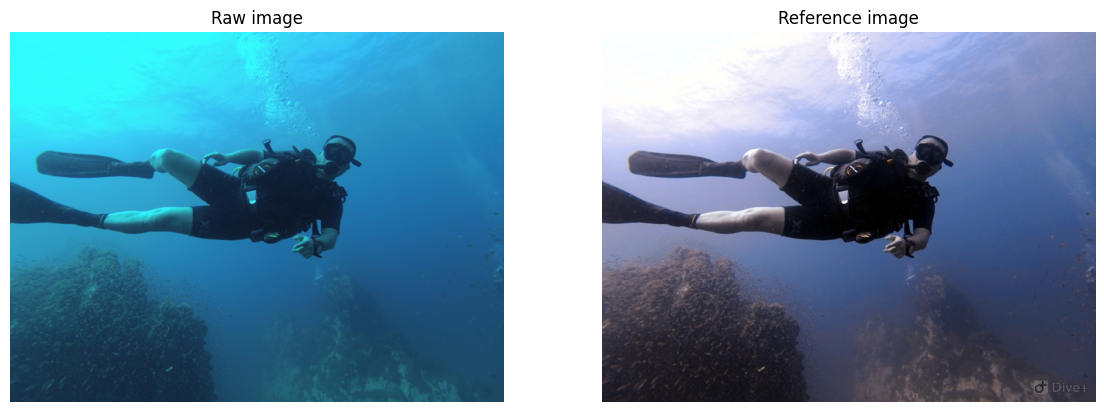

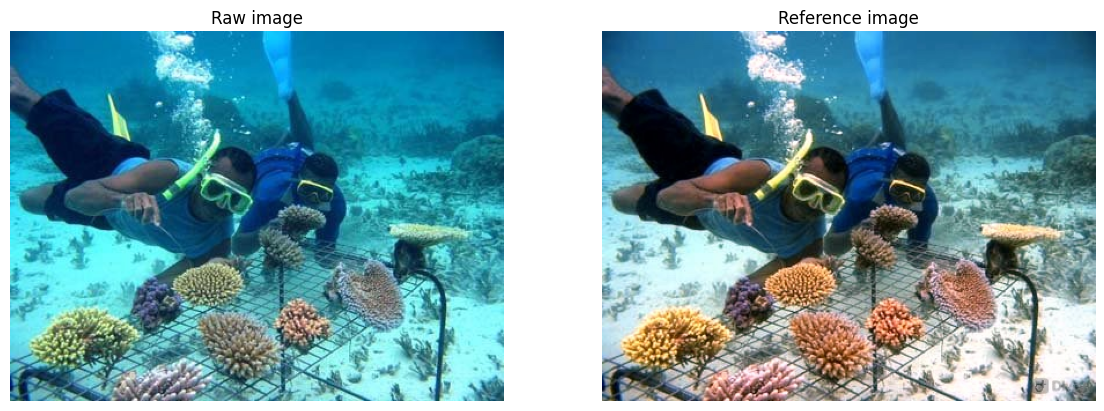

In [9]:
show_image_grid(image_path=images_raw, grid_size=(3, 6), image_size=(16, 8))


for i in range(1, 4):
    raw_img, ref_img = sample_images()
    compare_images([raw_img, ref_img], ["Raw image", "Reference image"], (14, 14))
plt.show()

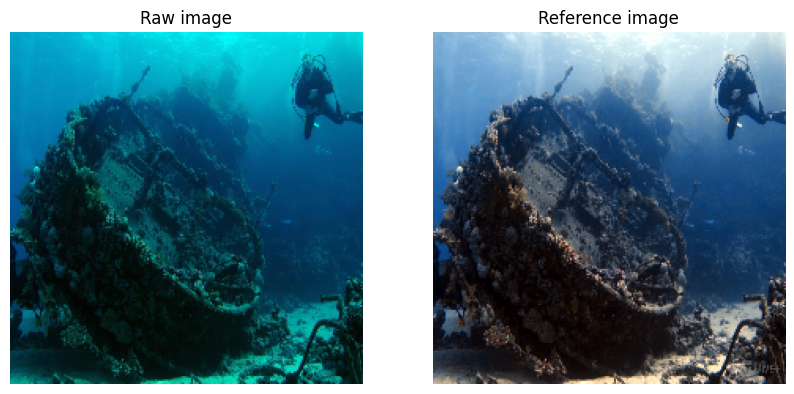

In [10]:
random_image, random_reference = sample_images(target_size=(224, 224))
compare_images(
    [random_image, random_reference], ["Raw image", "Reference image"], (10, 10)
)

In [11]:
actions_number = 20

seq_sharpen = iaa.Sequential([iaa.Sharpen(alpha=0.05)])
seq_emboss = iaa.Sequential([iaa.Emboss(alpha=0.05)])


def apply_action(action_code, img):

    if action_code in [0, 1]:
        factor = 1.05 if action_code == 0 else 0.95
        converter = ImageEnhance.Brightness(img)
        return converter.enhance(factor)

    elif action_code in [2, 3]:
        factor = 1.05 if action_code == 2 else 0.95
        converter = ImageEnhance.Contrast(img)
        return converter.enhance(factor)

    elif action_code in [4, 5]:
        factor = 1.05 if action_code == 4 else 0.95
        converter = ImageEnhance.Color(img)
        return converter.enhance(factor)

    elif action_code in [6, 7, 8, 9, 10, 11]:
        factor = 1.05 if action_code in [6, 8, 10] else 0.95

        red, green, blue = img.split()

        if action_code in [6, 7]:
            red = red.point(lambda i: i * factor)
        elif action_code in [8, 9]:
            green = green.point(lambda i: i * factor)
        else:
            blue = blue.point(lambda i: i * factor)

        return Image.merge("RGB", (red, green, blue))

    else:
        img_array = np.array(img)

        if action_code in [12, 13]:
            gamma = 1.5 if action_code == 12 else 0.5
            return gammaCorrection(img_array, gamma)

        elif action_code in [14, 15, 16]:
            opencv_image = cv.cvtColor(img_array, cv.COLOR_RGB2BGR)
            if action_code == 14:

                return heq(opencv_image)
            elif action_code == 15:

                return claheq(opencv_image)
            else:

                return white_balance(opencv_image)

        elif action_code in [17, 18]:
            img_array = np.expand_dims(img_array, axis=0)
            if action_code == 17:
                modified_array = seq_sharpen(images=img_array)
            else:
                modified_array = seq_emboss(images=img_array)
            return Image.fromarray(modified_array[0])

        elif action_code == 19:

            opencv_image = cv.cvtColor(img_array, cv.COLOR_RGB2BGR)

            return dehaze(opencv_image, refine=False)

        else:
            print("unsupported action", action_code)
            return img

In [12]:
def white_balance(opencv_image):
    result = cv.cvtColor(opencv_image, cv.COLOR_BGR2LAB)
    avg_a = np.average(result[:, :, 1])
    avg_b = np.average(result[:, :, 2])
    result[:, :, 1] = result[:, :, 1] - (
        (avg_a - 128) * (result[:, :, 0] / 255.0) * 1.1
    )
    result[:, :, 2] = result[:, :, 2] - (
        (avg_b - 128) * (result[:, :, 0] / 255.0) * 1.1
    )
    resultPil = cv.cvtColor(result, cv.COLOR_LAB2RGB)
    pil_image = Image.fromarray(resultPil)

    return pil_image

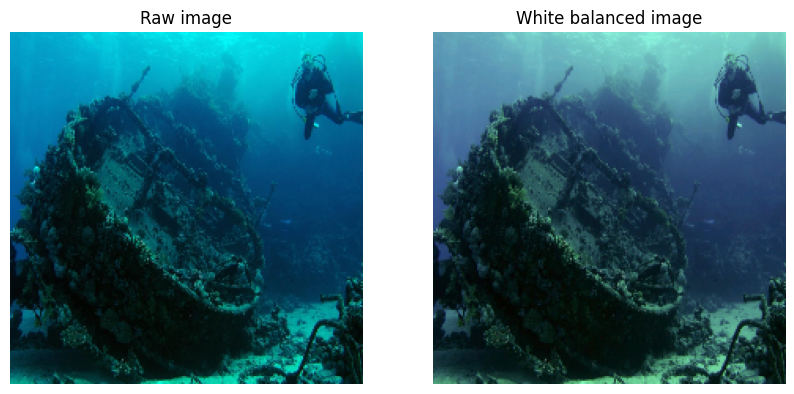

In [13]:
white_balanced_opencv = apply_action(action_code=16, img=random_image)

compare_images(
    [random_image, white_balanced_opencv],
    ["Raw image", "White balanced image"],
    (10, 10),
)

In [14]:
R, G, B = 0, 1, 2


def boxfilter(I, r):
    M, N = I.shape
    dest = np.zeros((M, N))

    sumY = np.cumsum(I, axis=0)

    dest[: r + 1] = sumY[r : 2 * r + 1]
    dest[r + 1 : M - r] = sumY[2 * r + 1 :] - sumY[: M - 2 * r - 1]
    dest[-r:] = np.tile(sumY[-1], (r, 1)) - sumY[M - 2 * r - 1 : M - r - 1]

    sumX = np.cumsum(dest, axis=1)

    dest[:, : r + 1] = sumX[:, r : 2 * r + 1]
    dest[:, r + 1 : N - r] = sumX[:, 2 * r + 1 :] - sumX[:, : N - 2 * r - 1]
    dest[:, -r:] = (
        np.tile(sumX[:, -1][:, None], (1, r)) - sumX[:, N - 2 * r - 1 : N - r - 1]
    )
    return dest


def guided_filter(I, p, r=40, eps=1e-3):
    M, N = p.shape
    base = boxfilter(np.ones((M, N)), r)

    means = [boxfilter(I[:, :, i], r) / base for i in range(3)]

    mean_p = boxfilter(p, r) / base

    means_IP = [boxfilter(I[:, :, i] * p, r) / base for i in range(3)]

    covIP = [means_IP[i] - means[i] * mean_p for i in range(3)]

    var = defaultdict(dict)
    for i, j in combinations_with_replacement(range(3), 2):
        var[i][j] = boxfilter(I[:, :, i] * I[:, :, j], r) / base - means[i] * means[j]
    a = np.zeros((M, N, 3))
    for y, x in np.ndindex(M, N):

        Sigma = np.array(
            [
                [var[R][R][y, x], var[R][G][y, x], var[R][B][y, x]],
                [var[R][G][y, x], var[G][G][y, x], var[G][B][y, x]],
                [var[R][B][y, x], var[G][B][y, x], var[B][B][y, x]],
            ]
        )
        cov = np.array([c[y, x] for c in covIP])
        a[y, x] = np.dot(cov, np.linalg.inv(Sigma + eps * np.eye(3)))

    b = mean_p - a[:, :, R] * means[R] - a[:, :, G] * means[G] - a[:, :, B] * means[B]

    q = (
        boxfilter(a[:, :, R], r) * I[:, :, R]
        + boxfilter(a[:, :, G], r) * I[:, :, G]
        + boxfilter(a[:, :, B], r) * I[:, :, B]
        + boxfilter(b, r)
    ) / base
    return q

In [15]:
class Node(object):
    def __init__(self, x, y, value):
        self.x = x
        self.y = y
        self.value = value

    def printInfo(self):
        print("%s:%s:%s" % (self.x, self.y, self.value))


def getMinChannel(img):
    if len(img.shape) == 3 and img.shape[2] == 3:
        pass
    else:
        print("bad image shape, input must be color image")
        return None

    return np.min(img, axis=2)


def getDarkChannel(img, blockSize=3):
    if len(img.shape) == 2:
        pass
    else:
        print("bad image shape, input image must be two dimensions")
        return None

    if blockSize % 2 == 0 or blockSize < 3:
        print("blockSize is not odd or too small")
        return None

    A = int((blockSize - 1) / 2)

    H = img.shape[0] + blockSize - 1
    W = img.shape[1] + blockSize - 1

    imgMiddle = 255 * np.ones((H, W))

    imgMiddle[A : H - A, A : W - A] = img

    imgDark = np.zeros_like(img, np.uint8)

    localMin = 255
    for i in range(A, H - A):
        for j in range(A, W - A):
            x = range(i - A, i + A + 1)
            y = range(j - A, j + A + 1)
            imgDark[i - A, j - A] = np.min(imgMiddle[x, y])

    return imgDark


def getAtomsphericLight(darkChannel, img, meanMode=False, percent=0.001):
    size = darkChannel.shape[0] * darkChannel.shape[1]
    height = darkChannel.shape[0]
    width = darkChannel.shape[1]

    nodes = []

    for i in range(0, height):
        for j in range(0, width):
            oneNode = Node(i, j, darkChannel[i, j])
            nodes.append(oneNode)

    nodes = sorted(nodes, key=lambda node: node.value, reverse=True)

    atomsphericLight = 0

    if int(percent * size) == 0:
        for i in range(0, 3):
            if img[nodes[0].x, nodes[0].y, i] > atomsphericLight:
                atomsphericLight = img[nodes[0].x, nodes[0].y, i]

        return atomsphericLight

    if meanMode:
        sum = 0
        for i in range(0, int(percent * size)):
            for j in range(0, 3):
                sum = sum + img[nodes[i].x, nodes[i].y, j]
        atomsphericLight = int(sum / (int(percent * size) * 3))
        return atomsphericLight

    for i in range(0, int(percent * size)):
        for j in range(0, 3):
            if img[nodes[i].x, nodes[i].y, j] > atomsphericLight:
                atomsphericLight = img[nodes[i].x, nodes[i].y, j]
    return atomsphericLight


def dehaze(
    img, omega=0.95, t0=0.1, blockSize=15, meanMode=False, percent=0.001, refine=True
):

    imgGray = getMinChannel(img)
    imgDark = getDarkChannel(imgGray, blockSize=blockSize)
    atomsphericLight = getAtomsphericLight(
        imgDark, img, meanMode=meanMode, percent=percent
    )

    imgDark = np.float64(imgDark)
    transmission = 1 - omega * imgDark / atomsphericLight

    transmission[transmission < 0.1] = 0.1

    if refine:
        normI = (img - img.min()) / (img.max() - img.min())
        transmission = guided_filter(normI, transmission, r=40, eps=1e-3)

    sceneRadiance = np.zeros(img.shape)
    img = np.float64(img)

    for i in range(3):
        SR = (img[:, :, i] - atomsphericLight) / transmission + atomsphericLight

        SR[SR > 255] = 255
        SR[SR < 0] = 0
        sceneRadiance[:, :, i] = SR

    sceneRadiance = np.uint8(sceneRadiance)
    resultPil = cv.cvtColor(sceneRadiance, cv.COLOR_BGR2RGB)
    return Image.fromarray(resultPil)

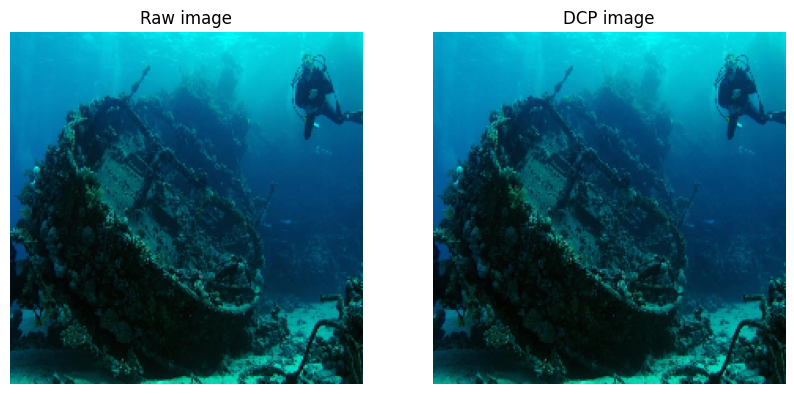

In [16]:
dcp_opencv = apply_action(action_code=19, img=random_image)

compare_images([random_image, dcp_opencv], ["Raw image", "DCP image"], (10, 10))

In [17]:
def gammaCorrection(opencv_image, gamma):

    invGamma = 1.0 / gamma
    table = np.array(
        [((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]
    ).astype("uint8")

    correctedArray = cv.LUT(opencv_image, table)
    return Image.fromarray(correctedArray)

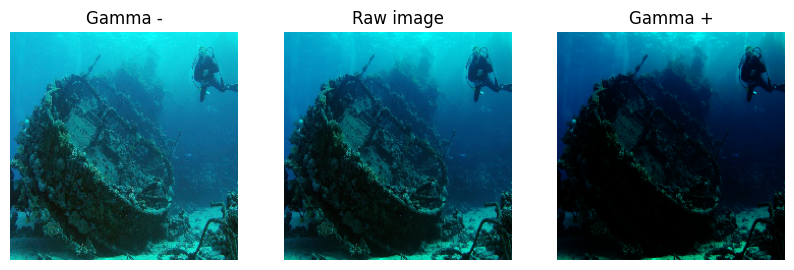

In [18]:
image_1 = apply_action(action_code=12, img=random_image)
image_2 = apply_action(action_code=13, img=random_image)

compare_images(
    [image_1, random_image, image_2], ["Gamma -", "Raw image", "Gamma +"], (10, 10)
)

In [19]:
def heq(opencv_image):
    img_to_yuv = cv.cvtColor(opencv_image, cv.COLOR_BGR2YUV)
    img_to_yuv[:, :, 0] = cv.equalizeHist(img_to_yuv[:, :, 0])
    hist_equalization_result = cv.cvtColor(img_to_yuv, cv.COLOR_YUV2BGR)
    resultPil = cv.cvtColor(hist_equalization_result, cv.COLOR_BGR2RGB)
    pil_image = Image.fromarray(resultPil)
    return pil_image

In [20]:
def claheq(opencv_image):
    img = cv.cvtColor(opencv_image, cv.COLOR_BGR2LAB)
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))

    img[:, :, 0] = clahe.apply(img[:, :, 0])
    img = cv.cvtColor(img, cv.COLOR_LAB2BGR)
    resultPil = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return Image.fromarray(resultPil)

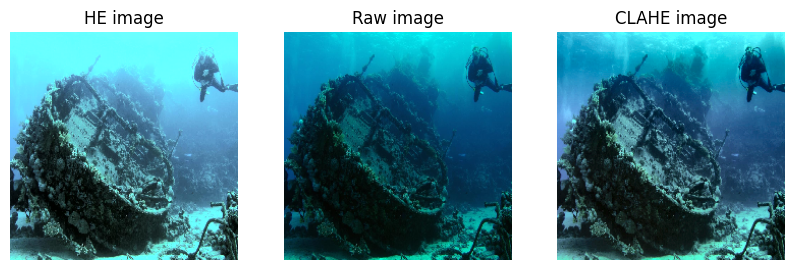

In [21]:
image_1 = apply_action(action_code=14, img=random_image)

image_2 = apply_action(action_code=15, img=random_image)
compare_images(
    [image_1, random_image, image_2], ["HE image", "Raw image", "CLAHE image"], (10, 10)
)

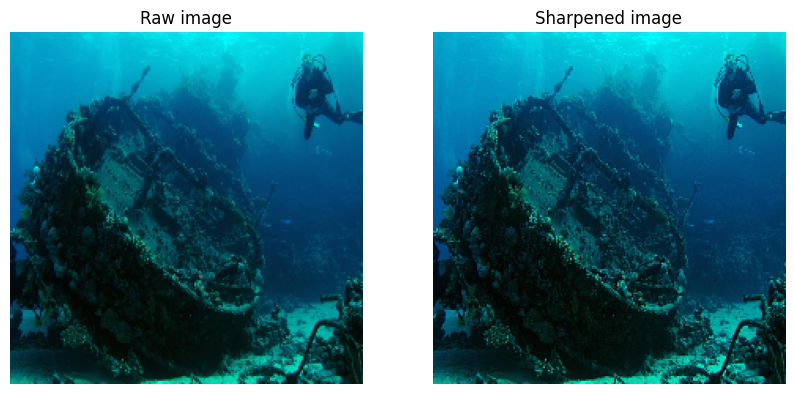

In [22]:
sharpenedImage = apply_action(action_code=17, img=random_image)

compare_images(
    [random_image, sharpenedImage], ["Raw image", "Sharpened image"], (10, 10)
)

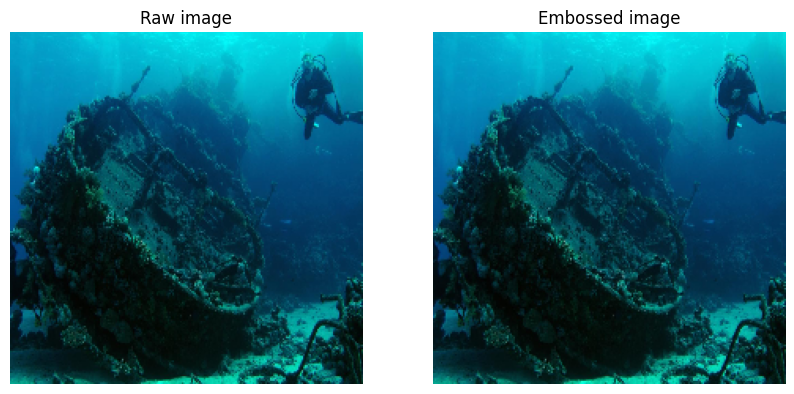

In [23]:
embossedImage = apply_action(action_code=18, img=random_image)

compare_images([random_image, embossedImage], ["Raw image", "Embossed image"], (10, 10))

Ranges for l,a,b:  [1, 232] [65, 141] [82, 153]
Shape: (256, 1)
Shape: (256, 1)
Shape: (256, 1)


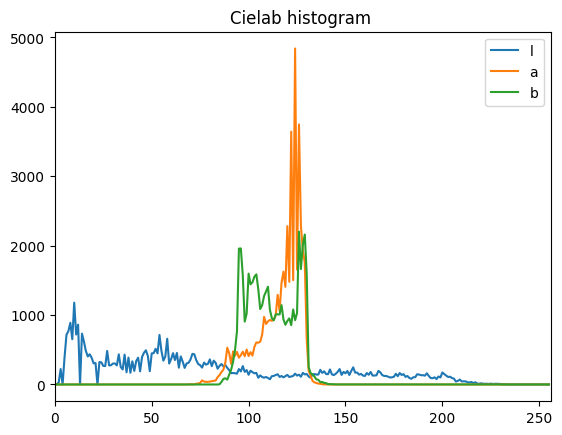

In [24]:
image_array = np.array(random_image)

lab = cv.cvtColor(image_array, cv.COLOR_RGB2LAB)
l_range = [np.min(lab[:, :, 0]), np.max(lab[:, :, 0])]
a_range = [np.min(lab[:, :, 1]), np.max(lab[:, :, 1])]
b_range = [np.min(lab[:, :, 2]), np.max(lab[:, :, 2])]
print("Ranges for l,a,b: ", l_range, a_range, b_range)


bin_count = 256

for i, col in enumerate(["l", "a", "b"]):
    hist = cv.calcHist([lab], [i], None, [bin_count], [0, 256])
    print("Shape:", hist.shape)
    plt.plot(hist, label=col)
    plt.xlim([0, bin_count])

plt.legend()
plt.title("Cielab histogram ")
plt.show()

In [25]:
def get_color_feature(img_array, flatten=False):

    lab = cv.cvtColor(img_array, cv.COLOR_RGB2LAB)

    channels = [0, 1, 2]
    bins = [20, 20, 20]
    ranges = [0, 256, 0, 256, 0, 256]

    histogram = cv.calcHist([lab], channels, None, bins, ranges)

    if flatten:
        return histogram.flatten()
    else:
        return histogram

In [26]:
image_array = np.array(random_image)
print("color feature are:", get_color_feature(image_array).size)

color feature are: 8000


In [27]:
vgg19 = VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

2024-05-26 09:34:56.568271: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-26 09:34:56.613745: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-26 09:34:56.614022: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [28]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [29]:
plot_model(vgg19, show_shapes=True)

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [ ]:
opt = Adam(learning_rate=0.001)

vgg19.compile(optimizer=opt, loss=categorical_crossentropy, metrics=["accuracy"])

In [ ]:
hidden_features_vgg = Model(inputs=vgg19.input, outputs=vgg19.get_layer("fc1").output)


def get_perceptual_features(img_array, model=hidden_features_vgg, flatten=False):
    image_values = np.expand_dims(img_array, axis=0)
    image_values = preprocess_input(image_values)

    features = model.predict(image_values, verbose="0")
    if flatten:
        return features.flatten()
    else:
        return features


features = get_perceptual_features(random_image)
print("number of perceptual feature: ", features.size)

In [ ]:
for layer in vgg19.layers:

    if "conv" not in layer.name:
        continue

    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

In [ ]:
for i in range(len(vgg19.layers)):
    layer = vgg19.layers[i]

    if "conv" not in layer.name:
        continue

    print(i, layer.name, layer.output.shape)

In [ ]:
display_image(random_image)

label = decode_predictions(get_perceptual_features(random_image, model=vgg19))


label_most = label[0][0]

print(
    "The most likely class obtained is: %s (%.2f%%)"
    % (label_most[1], label_most[2] * 100)
)

classes = []
probabilities = []
x = 0
while x < len(label[0]):
    classes.append(label[0][x][1])
    probabilities.append(label[0][x][2] * 100)
    x = x + 1

fig, ax = plt.subplots()
width = 0.8
rects1 = ax.barh(classes, probabilities, width, color="r")

ax.set_ylabel("Classes")
ax.set_xlabel("Probabilities")
ax.set_title("Probability")

plt.show()

In [ ]:
def get_features(img):
    img_array = np.array(img)

    color_features = get_color_feature(img_array, flatten=True)
    perceptual_features = get_perceptual_features(img_array, flatten=True)

    features = np.concatenate((color_features, perceptual_features))

    return features, color_features, perceptual_features

In [ ]:
features, color_features, perceptual_features = get_features(random_image)
features_number = len(features)

print("number of features: ", features_number)

In [ ]:
mae_loss = MeanAbsoluteError()


def get_pixelwise_reward(
    pre_img_color_features, post_img_color_features, ref_img_color_features
):
    pre_ref_mae = mae_loss(ref_img_color_features, pre_img_color_features).numpy()
    post_ref_mae = mae_loss(ref_img_color_features, post_img_color_features).numpy()
    return pre_ref_mae - post_ref_mae

In [ ]:
mse_loss = MeanSquaredError()


def get_perceptual_reward(
    pre_img_perc_features, post_img_perc_features, ref_img_perc_features
):
    pre_ref_mse = mse_loss(ref_img_perc_features, pre_img_perc_features).numpy()
    post_ref_mse = mse_loss(ref_img_perc_features, post_img_perc_features).numpy()
    return pre_ref_mse - post_ref_mse

In [ ]:
alpha = 1
beta = 0.05


def get_reward(
    pre_img_color_feats,
    pre_img_perc_feats,
    post_img_color_feats,
    post_img_perc_feats,
    ref_img_color_feats,
    ref_img_perc_feats,
):
    pixelwise_reward = get_pixelwise_reward(
        pre_img_color_feats, post_img_color_feats, ref_img_color_feats
    )
    perceptual_reward = get_perceptual_reward(
        pre_img_perc_feats, post_img_perc_feats, ref_img_perc_feats
    )
    return (alpha * pixelwise_reward) + (beta * perceptual_reward)

In [ ]:
f1, cf1, pf1 = get_features(random_image)
fr, cfr, pfr = get_features(random_reference)
print(get_reward(cf1, pf1, cf1, pf1, cfr, pfr))
print(get_reward(cf1, pf1, cfr, pfr, cfr, pfr))

In [ ]:
class Environment(Env):

    def __init__(self):
        super(Environment, self).__init__()
        self.image_size = (224, 224)
        self.reset()
        self.saved_score = 0

    def step(self, action):

        new_curr_img = apply_action(action_code=action, img=self.current_image)
        new_curr_img_feats, new_curr_img_col_feats, new_curr_img_perc_feats = (
            get_features(new_curr_img)
        )

        reward = get_reward(
            self.curr_img_col_feats,
            self.curr_img_perc_feats,
            new_curr_img_col_feats,
            new_curr_img_perc_feats,
            self.ref_img_col_feats,
            self.ref_img_perc_feats,
        )

        self.current_image = new_curr_img
        self.curr_img_feats = new_curr_img_feats
        self.curr_img_col_feats = new_curr_img_col_feats
        self.curr_img_perc_feats = new_curr_img_perc_feats

        return self.curr_img_feats, reward

    def reset(self, raw_path=None, ref_path=None):

        if not raw_path is None and not ref_path is None:
            self.raw_image = load_img(path=raw_path, target_size=self.image_size)
            self.reference_image = load_img(path=ref_path, target_size=self.image_size)
        else:
            self.raw_image, self.reference_image = sample_images(
                target_size=self.image_size
            )

        self.raw_img_feats, self.raw_img_col_feats, self.raw_img_perc_feats = (
            get_features(self.raw_image)
        )
        self.ref_img_feats, self.ref_img_col_feats, self.ref_img_perc_feats = (
            get_features(self.reference_image)
        )

        self.current_image = self.raw_image
        self.curr_img_feats = self.raw_img_feats
        self.curr_img_col_feats = self.raw_img_col_feats
        self.curr_img_perc_feats = self.raw_img_perc_feats
        self.saved_score = 0

        return self.curr_img_feats

    def render(self):
        compare_images(
            [self.raw_image, self.current_image, self.reference_image],
            ["raw image", "enhanced image", "reference image"],
            (14, 14),
        )

In [ ]:
env = Environment()
env.render()


for i in range(0, 20):
    action_begin_time = time.time()
    img, reward = env.step(i)


env.render()

In [ ]:
def build_dqn(neuron_in_input_layer, neuron_in_hidden_layers, neuron_in_output_layer):
    model = Sequential()

    model.add(layers.Input(shape=(neuron_in_input_layer,), name="Input"))

    for n in neuron_in_hidden_layers:
        model.add(layers.Dense(n, activation="relu"))

    model.add(layers.Dense(neuron_in_output_layer, name="Output"))

    return model


neuron_in_hidden_layers = (4096, 4096, 512)

In [ ]:
dqn = build_dqn(features_number, neuron_in_hidden_layers, actions_number)

In [ ]:
dqn.summary()

In [ ]:
plot_model(dqn, show_shapes=True)

In [ ]:
opt = Adam(learning_rate=0.001)

dqn.compile(optimizer=opt, loss="mse", metrics=["accuracy"])

In [ ]:
class Memory:
    def __init__(self, max_length):
        self.max_length = max_length
        self.reset()

    def store(self, state, action, reward, next_state, done):
        if self.stored_transitions < self.max_length:
            self.action_list[self.stored_transitions] = action
            self.state_list[self.stored_transitions] = state
            self.reward_list[self.stored_transitions] = reward
            self.next_state_list[self.stored_transitions] = next_state
            self.done_list[self.stored_transitions] = done
            self.stored_transitions += 1

    def sample(self, batch_size):

        index = sample(range(0, self.stored_transitions), batch_size)

        return (
            self.state_list[index],
            self.action_list[index],
            self.reward_list[index],
            self.next_state_list[index],
            self.done_list[index],
        )

    def reset(self):
        self.state_list = np.zeros((self.max_length, features_number), dtype=np.float32)
        self.action_list = np.zeros(self.max_length, dtype=np.int32)
        self.reward_list = np.zeros(self.max_length, dtype=np.float32)
        self.next_state_list = np.zeros(
            (self.max_length, features_number), dtype=np.float32
        )
        self.done_list = np.zeros((self.max_length), dtype=bool)
        self.stored_transitions = 0

In [ ]:
class DoubleDeepQNetwork:

    def __init__(
        self,
        state_size,
        actions_number,
        memory_length,
        alpha,
        gamma,
        epsilon,
        epsilon_min,
        epsilon_decay_rate,
        alpha_min,
        alpha_decay_step,
        alpha_decay_rate,
    ):
        self.memory = Memory(max_length=memory_length)
        self.alpha = alpha
        self.gamma = gamma

        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay_rate = epsilon_decay_rate

        self.evaluation_model = build_dqn(
            state_size, neuron_in_hidden_layers, actions_number
        )
        self.target_model = self.evaluation_model

        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=alpha,
            decay_steps=alpha_decay_step,
            decay_rate=alpha_decay_rate,
        )
        self.optimizer = Adam(learning_rate=lr_schedule)
        self.evaluation_model.compile(
            optimizer=self.optimizer, loss="mse", metrics=["accuracy"]
        )

        self.update_target_from_eval()
        self.loss = []
        self.actions_number = actions_number

    def update_target_from_eval(self):

        self.target_model.set_weights(self.evaluation_model.get_weights())

    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            action = randrange(self.actions_number)

        else:
            state = np.expand_dims(state, axis=0)
            action_vals = self.evaluation_model.predict(state, verbose="0")
            action = np.argmax(action_vals[0])

        return action

    def check_if_done(self, state):

        state = np.expand_dims(state, axis=0)
        action_vals = self.evaluation_model.predict(state, verbose="0")
        if np.max(action_vals[0]) < 0:
            return True
        else:
            return False

    def train(self, batch_size):

        states, actions, rewards, next_states, dones = self.memory.sample(batch_size)

        eval_q_values = self.evaluation_model.predict(states, verbose="0")

        target_q_values = eval_q_values

        next_eval_q_values = self.evaluation_model.predict(next_states, verbose="0")
        next_target_q_values = self.target_model.predict(next_states, verbose="0")

        for batch_index in range(len(states)):
            best_next_action_index = np.argmax(next_eval_q_values[batch_index])

            if dones[batch_index]:
                target_q_values[batch_index][best_next_action_index] = rewards[
                    batch_index
                ]
            else:
                target_q_values[batch_index][best_next_action_index] = rewards[
                    batch_index
                ] + (
                    self.gamma
                    * next_target_q_values[batch_index][best_next_action_index]
                )

        self.evaluation_model.train_on_batch(states, target_q_values)

    def store(self, state, action, reward, nstate, done):

        self.memory.append((state, action, reward, nstate, done))

    def epsilon_decay(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay_rate)

In [ ]:
learning_rate = 1e-5
min_learning_rate = 1e-8
learning_rate_decade_step = 5000
learning_rate_decay_rate = 0.96
discount_rate = 0.99
batch_size = 32
epsilon = 1
epsilon_min = 0.1
epsilon_decay_rate = 0.9996

episodes = 10_000
actions_number = 20


backup_weights = True

load_weights = False

episode_max_steps = 50
step_per_update_eval_dqn = 10
step_per_update_targ_dqn = episode_max_steps
mem_length = 50_000

ddqn = DoubleDeepQNetwork(
    state_size=features_number,
    actions_number=actions_number,
    memory_length=mem_length,
    alpha=learning_rate,
    gamma=discount_rate,
    epsilon=epsilon,
    epsilon_min=epsilon_min,
    epsilon_decay_rate=epsilon_decay_rate,
    alpha_min=min_learning_rate,
    alpha_decay_step=learning_rate_decade_step,
    alpha_decay_rate=learning_rate_decay_rate,
)

In [ ]:
def train_ddqn():
    total_step_count = 0
    training_start_time = time.time()
    moving_avg_window_size = 20
    train_rewards = []

    for episode in range(episodes):
        episode_start_time = time.time()
        state = env.reset()
        episode_reward = 0
        done = False
        step_count = 0

        while not done:
            step_count += 1
            total_step_count += 1

            action = ddqn.select_action(state)
            next_state, reward = env.step(action)
            episode_reward += reward
            done = ddqn.check_if_done(next_state)
            ddqn.memory.store(state, action, reward, next_state, done)
            state = next_state

            if (
                step_count % step_per_update_eval_dqn == 0
                and ddqn.memory.stored_transitions >= batch_size
            ):
                ddqn.train(batch_size)

            if step_count % step_per_update_targ_dqn == 0:
                ddqn.update_target_from_eval()

            if done or step_count >= episode_max_steps:
                train_rewards.append(episode_reward)

                episode_finish_time = time.time()
                episode_elapsed_time = episode_finish_time - episode_start_time
                training_elapsed_time = episode_finish_time - training_start_time
                moving_avg_reward = mean(train_rewards[-moving_avg_window_size:])
                print(
                    "Episode: {}/{}, steps: {}[{}], Total reward: {}[{:.1f}], time: {:.1f}s[{:.1f}m], e: {}".format(
                        episode + 1,
                        episodes,
                        step_count,
                        total_step_count,
                        episode_reward,
                        moving_avg_reward,
                        episode_elapsed_time,
                        training_elapsed_time / 60,
                        ddqn.epsilon,
                    )
                )
                ddqn.epsilon_decay()

                if backup_weights and episode % 100 == 0:
                    ddqn.evaluation_model.save_weights(
                        "evalDqn-epsiode{}.weights.h5".format(episode)
                    )

                break

    training_finish_time = time.time()
    training_elapsed_time = training_finish_time - training_start_time
    print(
        "training time: {:.1f}m, average episode time: {:.1f}s".format(
            training_elapsed_time / 60, training_elapsed_time / episodes
        )
    )

    plot_training_rewards(train_rewards, moving_avg_window_size)

In [ ]:
if load_weights:
    print("loading weights from local file")
    local_weights_path = "evalDqn-episode20k.h5"
    ddqn.evaluation_model.load_weights(local_weights_path)
else:
    print("starting training")
    train_ddqn()

In [ ]:
if not load_weights:
    total_mse = total_psnr = total_ssim = 0
    ddqn.epsilon = 0

    env.image_size = (224, 224)

    for index, (raw_path, ref_path) in enumerate(zip(images_raw_val, images_ref_val)):
        state = env.reset(raw_path, ref_path)
        tot_rewards = 0
        done = False
        step_count = 1

        while not done:
            action = ddqn.select_action(state)
            new_state, reward = env.step(action)
            done = ddqn.check_if_done(state)
            tot_rewards += reward
            state = new_state

            if done or step_count >= 10:

                mse = mean_squared_error(
                    np.array(env.current_image), np.array(env.reference_image)
                )
                psnr = peak_signal_noise_ratio(
                    np.array(env.current_image), np.array(env.reference_image)
                )
                ssim = structural_similarity(
                    im1=np.array(env.current_image),
                    im2=np.array(env.reference_image),
                    multichannel=True,
                )
                print(
                    "episode: {}, steps: {}, episode reward: {}, mse: {}, psnr: {}, ssim: {}".format(
                        index, step_count, tot_rewards, mse, psnr, ssim
                    )
                )
                total_mse += mse
                total_psnr += psnr
                total_ssim += ssim
                break
            step_count += 1

    avg_mse = total_mse / len(images_raw_val)
    avg_psnr = total_psnr / len(images_raw_val)
    avg_ssim = total_ssim / len(images_raw_val)

    print(
        "lr: {}, alpha: {}, beta: {}, episode: {} with max steps {}".format(
            learning_rate, alpha, beta, episodes, episode_max_steps
        )
    )
    print("avg mse: {}, avg_psnr: {}, avg ssim: {}".format(avg_mse, avg_psnr, avg_ssim))

In [ ]:
def repository_get_reward(previous_score, actual_image, target_image):
    target_lab = skimage.color.rgb2lab(target_image)
    data_lab = skimage.color.rgb2lab(actual_image)
    new_score = mean_squared_error(target_lab, data_lab)

    new_reward = previous_score - new_score

    return new_reward, new_score

In [ ]:
TEST_Episodes = 5
ddqn.epsilon = 0
max_test_episode_step = 10

for e_test in range(TEST_Episodes):
    state = env.reset()
    done = False
    step_count = 1
    while not done:
        action = ddqn.select_action(state)
        new_state, _ = env.step(action)
        done = ddqn.check_if_done(state)
        state = new_state
        if done or step_count >= max_test_episode_step:
            env.render()
            break
        step_count += 1

In [ ]:
ddqn.epsilon = 0
max_test_episode_step = 10
total_mse = total_psnr = total_ssim = 0

for index, (raw_path, ref_path) in enumerate(zip(images_raw_test, images_ref_test)):
    state = env.reset(raw_path, ref_path)
    tot_rewards = 0
    done = False
    step_count = 1
    while not done:
        action = ddqn.select_action(state)
        new_state, reward = env.step(action)
        done = ddqn.check_if_done(state)
        tot_rewards += reward
        state = new_state
        if done or step_count >= max_test_episode_step:

            mse = mean_squared_error(
                np.array(env.current_image), np.array(env.reference_image)
            )
            psnr = peak_signal_noise_ratio(
                np.array(env.current_image), np.array(env.reference_image)
            )
            ssim = structural_similarity(
                im1=np.array(env.current_image),
                im2=np.array(env.reference_image),
                channel_axis=2,
            )
            print(
                "episode: {}/{}, steps: {}, episode reward: {}".format(
                    index, len(images_raw_test), step_count, tot_rewards
                )
            )
            total_mse += mse
            total_psnr += psnr
            total_ssim += ssim
            break
        step_count += 1

avg_mse = total_mse / len(images_raw_val)
avg_psnr = total_psnr / len(images_raw_val)
avg_ssim = total_ssim / len(images_raw_val)

print(
    "lr: {}, alpha: {}, beta: {}, episode: {} with max steps {}".format(
        learning_rate, alpha, beta, episodes, episode_max_steps
    )
)
print("avg mse: {}, avg_psnr: {}, avg ssim: {}".format(avg_mse, avg_psnr, avg_ssim))